# Probabilistic PCA

Probabilistic principal components analysis (PCA) is a
dimensionality reduction technique that
analyzes data via a lower dimensional latent space
([Tipping and Bishop 1999](#1)). It is often
used when there are missing values in the data or for multidimensional
scaling.

## Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

## The Model

Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}

The corresponding data point is generated via a projection,

\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^Y + \sigma^2\mathbf{I}).
\end{equation*}

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we assume $\sigma$ is known, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes.

In [0]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints): # (unmodeled) data
  w = ed.Normal(loc=tf.zeros([data_dim, latent_dim]),
                scale=2.0 * tf.ones([data_dim, latent_dim]),
                name="w")  # parameter
  z = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                scale=tf.ones([latent_dim, num_datapoints]), 
                name="z")  # parameter
  x = ed.Normal(loc=tf.matmul(w, z),
                scale=stddv_datapoints * tf.ones([data_dim, num_datapoints]),
                name="x")  # (modeled) data
  return x, (w, z)

log_joint = ed.make_log_joint_fn(ppca_model)

## The Data

We can use the Edward2 model to generate data.

In [3]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

model = ppca_model(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints)

with tf.Session() as sess:
  x_train, (actual_w, actual_z) = sess.run(model)

print("Principal axes:")
print(actual_w)

Principal axes:
[[-1.25273824]
 [ 2.15866327]]


We visualize the dataset.

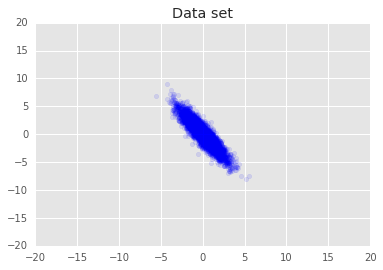

In [4]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()

## Maximum a Posteriori Inference

We first search for the point estimate of latent variables that maximizes the posterior probability density. This is known as maximum a posteriori (MAP) inference, and is done by calculating the values of $\mathbf{W}$ and $\mathbf{Z}$ that maximise the posterior density $p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X}) \propto p(\mathbf{W}, \mathbf{Z}, \mathbf{X})$.


In [0]:
tf.reset_default_graph()

w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)


def target(w, z):
  """Unnormalized target density as a function of the parameters."""
  return log_joint(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints,
                   w=w, z=z, x=x_train)


energy = -target(w, z)

optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
train = optimizer.minimize(energy)

init = tf.global_variables_initializer()

t = []

num_epochs = 200

with tf.Session() as sess:
  sess.run(init)

  for i in range(num_epochs):
    sess.run(train)
    if i % 5 == 0:
      cE, cw, cz = sess.run([energy, w, z])
      t.append(cE)

  w_inferred_map = sess.run(w)
  z_inferred_map = sess.run(z)

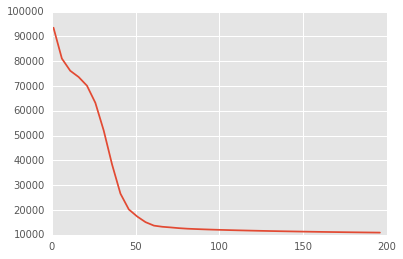

In [6]:
x = range(1, num_epochs, 5)
plt.plot(x, t)

We can use the Edward2 model to sample data for the inferred values for $\mathbf{W}$ and $\mathbf{Z}$, and compare to the actual dataset we conditioned on. 

MAP-estimated axes:
[[-1.64202332]
 [ 2.83261108]]


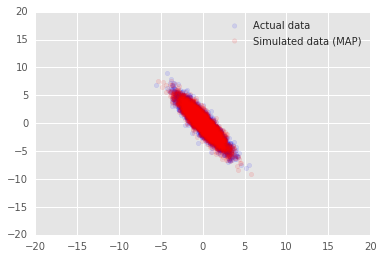

In [7]:
print("MAP-estimated axes:")
print(w_inferred_map)

def replace_latents(w=actual_w, z=actual_z):

  def interceptor(rv_constructor, *rv_args, **rv_kwargs):
    """Replaces the priors with actual values to generate samples from."""
    name = rv_kwargs.pop("name")
    if name == "w":
      rv_kwargs["value"] = w
    elif name == "z":
      rv_kwargs["value"] = z
    return rv_constructor(*rv_args, **rv_kwargs)

  return interceptor

with ed.interception(replace_latents(w_inferred_map, z_inferred_map)):
  generate = ppca_model(
      data_dim=data_dim, latent_dim=latent_dim,
      num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints)

with tf.Session() as sess:
  x_generated, _ = sess.run(generate)

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

## Variational Inference

MAP can be used to find the mode (or one of the modes) of the posterior distribution, but does not provide any other insights about it. We next use variational inference, where the posterior distribtion $p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X})$ is approximated using a variational distribution $q(\mathbf{W}, \mathbf{Z})$ parametrised by $\boldsymbol{\lambda}$. The aim is to find the variational parameters $\boldsymbol{\lambda}$ that _minimize_ the KL divergence between q and the posterior, $\mathrm{KL}(q(\mathbf{W}, \mathbf{Z}) \mid\mid p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X}))$, or equivalently, that _maximize_ the evidence lower bound, $\mathbb{E}_{q(\mathbf{W},\mathbf{Z};\boldsymbol{\lambda})}\left[ \log p(\mathbf{W},\mathbf{Z},\mathbf{X}) - \log q(\mathbf{W},\mathbf{Z}; \boldsymbol{\lambda}) \right]$.


In [0]:
tf.reset_default_graph()

def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
  qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
  qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
  return qw, qz


log_q = ed.make_log_joint_fn(variational_model)

def target_q(qw, qz):
  return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
               qz_mean=qz_mean, qz_stddv=qz_stddv,
               qw=qw, qz=qz)


qw_mean = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
qz_mean = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([data_dim, latent_dim]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, num_datapoints]), dtype=tf.float32))

qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                           qz_mean=qz_mean, qz_stddv=qz_stddv)

energy = target(qw, qz)
entropy = -target_q(qw, qz)

elbo = energy + entropy


optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
train = optimizer.minimize(-elbo)

init = tf.global_variables_initializer()

t = []

num_epochs = 100

with tf.Session() as sess:
  sess.run(init)

  for i in range(num_epochs):
    sess.run(train)
    if i % 5 == 0:
      t.append(sess.run([elbo]))

  w_mean_inferred = sess.run(qw_mean)
  w_stddv_inferred = sess.run(qw_stddv)
  z_mean_inferred = sess.run(qz_mean)
  z_stddv_inferred = sess.run(qz_stddv)

Inferred axes:
[[-1.07467461]
 [ 1.86692524]]
Standard Deviation:
[[ 0.01284163]
 [ 0.01477032]]


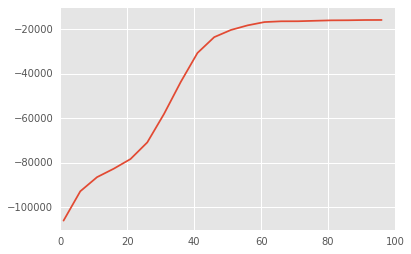

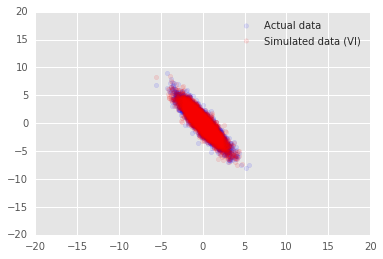

In [9]:
print("Inferred axes:")
print(w_mean_inferred)
print("Standard Deviation:")
print(w_stddv_inferred)

plt.plot(range(1, num_epochs, 5), t)
plt.show()

with ed.interception(replace_latents(w_mean_inferred, z_mean_inferred)):
  generate = ppca_model(
      data_dim=data_dim, latent_dim=latent_dim,
      num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints)

with tf.Session() as sess:
  x_generated, _ = sess.run(generate)

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

## Acknowledgements

This tutorial was originally written in Edward 1.0 ([source](https://github.com/blei-lab/edward/blob/master/notebooks/probabilistic_pca.ipynb)). We thank all contributors to writing and revising that version.

#### References

<a name='1'></a>[1]: Michael E. Tipping and Christopher M. Bishop. Probabilistic principal component analysis. _Journal of the Royal Statistical Society: Series B (Statistical Methodology)_, 61(3): 611-622, 1999.